# Solutions :

Here are the Parameters used in this Model to achieve an Validation Accuracy of over 95% : 

- Epochs : 16 Epochs
- Batch Size : 256
- Optimizers : Adam Optimizer 
- Data Augmentation : 
    - We Augmented the Minority Class and also some Major Classes to Make sure all classes have nearly Equal weightage
    - Class Weightage : During the Training we ask the Optimizer to Weight all classes equally despite their imbalance using the parameter we pass called as class_weights
- Model : We have used an Dropout after the second Convolution Layer to prevent Over-fitting.

[How to Set Class weights in Keras](https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras)

In [1]:
import sys
sys.path.append('/workspace/python/source_code')
from utils import * 
import os

def augmentation(name,category,filenames,labels,i):
    # Important Constants
    file_path = "Dataset/Aug/"
    images = []
    (h, w) = (232,232)
    center = (w / 2, h / 2)
    angle90 = 90
    angle180 = 180
    angle270 = 270
    scale = 1.0
    img = load_image(name , interpolation = cv2.INTER_AREA)
    if category == 0 :
        images.append(cv2.flip(img,0))
        images.append(cv2.flip(img,1))
        images.append(cv2.warpAffine(img, cv2.getRotationMatrix2D(center, angle90, scale), (h, w)))
        images.append(cv2.warpAffine(img, cv2.getRotationMatrix2D(center, angle180, scale), (w, h)))
        images.append(cv2.warpAffine(img, cv2.getRotationMatrix2D(center, angle270, scale), (h, w)))
    elif category == 1 :
        images.append(cv2.flip(img,0))
    elif category == 2 :
        pass
    elif category == 3 :
        pass
    elif category == 4 :
        images.append(cv2.flip(img,0))
    elif category == 5 :
        images.append(cv2.flip(img,0))
    elif category == 6 :
        images.append(cv2.flip(img,0))
    elif category == 7 :
        images.append(cv2.flip(img,0))
        images.append(cv2.flip(img,1))
        images.append(cv2.warpAffine(img, cv2.getRotationMatrix2D(center, angle90, scale), (h, w)))
        images.append(cv2.warpAffine(img, cv2.getRotationMatrix2D(center, angle180, scale), (w, h)))
        images.append(cv2.warpAffine(img, cv2.getRotationMatrix2D(center, angle270, scale), (h, w)))
    for j in range(len(images)):
        cv2.imwrite(file_path+str(i+j)+'.jpeg',images[j])
        filenames.append(file_path+str(i+j)+'.jpeg')
        labels.append(category)
    i = i + len(images)
    return i

In [2]:
filenames,labels = load_dataset(augment_fn = augmentation)

................................
45169


In [3]:
# Set the Size of the Validation set
val_filenames , val_labels = make_test_set(filenames,labels,val=0.1)

[564, 564, 564, 564, 564, 564, 564, 564]
Counter({1: 7730, 2: 7716, 4: 5992, 3: 5119, 5: 4796, 6: 4480, 7: 2724, 0: 2100})


In [4]:
#Make train test set 
test = 0.2
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(filenames, labels, test_size=test, random_state=1)

In [5]:
# Because the Classes are Unbalanced , we will be adding weights to the class using this function.
import numpy as np
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

In [6]:
import tensorflow as tf
y_train = tf.one_hot(y_train,depth=8)
y_test = tf.one_hot(y_test,depth=8)
val_labels = tf.one_hot(val_labels,depth=8)

In [7]:
# Make Dataset compatible with Tensorflow Data Pipelining.
train,test,val = make_dataset((x_train,y_train,256),(x_test,y_test,32),(val_filenames,val_labels,32))

# Defining the Model

In [8]:
import numpy as np
np.random.seed(1337)

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten ,Dropout, MaxPooling2D
from tensorflow.keras import backend as K 

#Reset Graphs and Create Sequential model

K.clear_session()
model = Sequential()

#Convolution Layers

model.add(Conv2D(64, kernel_size=10,strides=3, activation='relu', input_shape=(232,232,3)))
model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
model.add(Conv2D(256, kernel_size=5,strides=1,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
model.add(Dropout(0.5))
model.add(Conv2D(288, kernel_size=3,strides=1,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=1))
model.add(Conv2D(272, kernel_size=3,strides=1,padding='same',activation='relu'))
model.add(Conv2D(256, kernel_size=3,strides=1,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=2))
model.add(Dropout(0.5))
model.add(Flatten())

#Linear Layers 

model.add(Dense(3584,activation='relu'))
model.add(Dense(2048,activation='relu'))
model.add(Dense(8, activation='softmax'))

# Print Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 256)       409856    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 288)       663840    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 288)       0

# Training the Model

In [9]:
#Define Batch Size and Number of Epochs
epochs = 16
import functools
import tensorflow

# Include Top-2 Accuracy Metrics 
top2_acc = functools.partial(tensorflow.keras.metrics.top_k_categorical_accuracy, k=2)
top2_acc.__name__ = 'top2_acc'

#Compile Model with Loss Function , Optimizer and Metrics
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, 
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['accuracy',top2_acc])

# Train the Model 
trained_model = model.fit(train,validation_data=val,epochs=epochs,class_weight=class_weights)

# Test Model Aganist Validation Set
score = model.evaluate(test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#Save Our Model and Weights
model.save('cyc_pred_first.h5')
model.save_weights('model_weights_first.h5')

Epoch 1/16
128/128 [==============================] - 33s 255ms/step - loss: 2.2549 - accuracy: 0.2262 - top2_acc: 0.4311 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_top2_acc: 0.0000e+00
Epoch 2/16
128/128 [==============================] - 48s 377ms/step - loss: 1.4033 - accuracy: 0.4202 - top2_acc: 0.6689 - val_loss: 1.3685 - val_accuracy: 0.4156 - val_top2_acc: 0.6800
Epoch 3/16
128/128 [==============================] - 68s 534ms/step - loss: 1.1005 - accuracy: 0.5502 - top2_acc: 0.7826 - val_loss: 0.8892 - val_accuracy: 0.6480 - val_top2_acc: 0.8457
Epoch 4/16
128/128 [==============================] - 67s 525ms/step - loss: 0.8395 - accuracy: 0.6678 - top2_acc: 0.8688 - val_loss: 0.7111 - val_accuracy: 0.7143 - val_top2_acc: 0.8936
Epoch 5/16
128/128 [==============================] - 69s 542ms/step - loss: 0.6006 - accuracy: 0.7714 - top2_acc: 0.9208 - val_loss: 0.5447 - val_accuracy: 0.8010 - val_top2_acc: 0.9342
Epoch 6/16
128/128 [==============================] -

# Visualisations

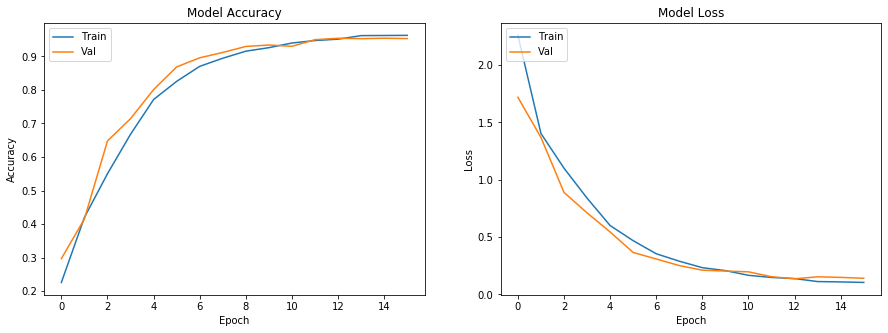

In [10]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax.plot(trained_model.history['accuracy'])
ax.plot(trained_model.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Val'])

ax2 = f.add_subplot(122)
ax2.plot(trained_model.history['loss'])
ax2.plot(trained_model.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Val'],loc= 'upper left')

plt.show()

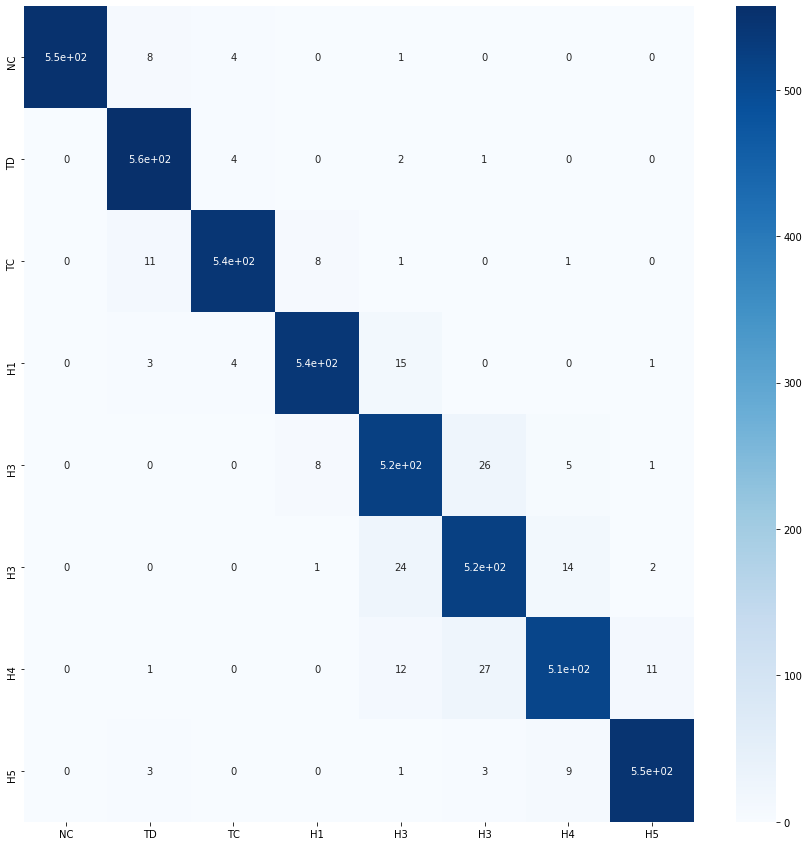

In [11]:
#Plotting a heatmap using the confusion matrix
pred = model.predict(val)
p = np.argmax(pred, axis=1)
y_valid = np.argmax(val_labels, axis=1, out=None)
import seaborn as sn
from sklearn.metrics import confusion_matrix
import pandas as pd
results = confusion_matrix(y_valid, p) 
classes=['NC','TD','TC','H1','H3','H3','H4','H5']
df_cm = pd.DataFrame(results, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (15,15))

sn.heatmap(df_cm, annot=True, cmap="Blues")